# Generating digits
From mnist

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

from datetime import datetime

Using TensorFlow backend.


# Hyperparameters
Set hyperparameters and and load dataset

In [2]:
mnist_data = mnist.load_data()
_, img_rows, img_cols = mnist_data[0][0].shape
channels = 1

img_shape = (img_rows, img_cols, channels)

# Size of the noise vector
z_dim = 100

# Generator

In [3]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    
    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))
    
    # Activation
    model.add(LeakyReLU(alpha=0.01))
    
    # Output layer
    model.add(Dense(img_rows * img_cols * channels, activation='tanh'))
    
    # Reshape the generator output to image dimensions
    model.add(Reshape(img_shape))
    
    return model

# Discriminator

In [4]:
def build_discriminator(img_shape):
    
    model = Sequential()
    
    # input image
    model.add(Flatten(input_shape=img_shape))
    
    model.add(Dense(128))
    
    # Activation
    model.add(LeakyReLU(alpha=0.01))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Build the model

In [5]:
def build_gan(generator, discriminator):
    
    model = Sequential()
    
    # Combined Generator <-> Discriminator
    model.add(generator)
    model.add(discriminator)
    
    return model

In [6]:
# Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Generator
generator = build_generator(img_shape, z_dim)

# Keeps discriminator's parameters constant for generator training
discriminator.trainable = False

# Build and compile
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Training

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iteractions, batch_size, sample_interval):
    (X_train, _), (_,_) = mnist_data
    # Rescale mnist data from [0, 255] to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    
    # Labels for real images
    real = np.ones((batch_size, 1))
    
    # Labels for fake images
    fake = np.zeros((batch_size, 1))
    
    # Get time
    start_training = datetime.now()
    
    for iteration in range(iteractions):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train the generator
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            now = datetime.now()
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            print(f'Elapsed time: {now - start_training} - {now}')
            
            # Output a generated image sample
            sample_images(generator)

    now = datetime.now()
    print(f'Total elapsed time: {now - start_training} - {now}')

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_cols=4):
    # Random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_cols, z_dim))
    
    gen_imgs = generator.predict(z)
    
    # Rescale values to 0, 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_cols,
                           figsize=(4, 4),
                           sharey=True,
                           sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

# Train the GAN and inspect output

/home/stelling/miniconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/stelling/miniconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.051601, acc.: 99.22%] [G loss: 3.577865]
Elapsed time: 0:00:17.315267 - 2019-09-17 12:51:55.997544
2000 [D loss: 0.049148, acc.: 98.44%] [G loss: 5.860942]
Elapsed time: 0:00:32.793060 - 2019-09-17 12:52:11.475337
3000 [D loss: 0.136556, acc.: 93.75%] [G loss: 5.401570]
Elapsed time: 0:00:48.421375 - 2019-09-17 12:52:27.103652
4000 [D loss: 0.228126, acc.: 91.02%] [G loss: 4.573697]
Elapsed time: 0:01:03.450775 - 2019-09-17 12:52:42.133052
5000 [D loss: 0.331415, acc.: 85.94%] [G loss: 3.241942]
Elapsed time: 0:01:17.725609 - 2019-09-17 12:52:56.407886
6000 [D loss: 0.117444, acc.: 94.53%] [G loss: 4.800687]
Elapsed time: 0:01:32.285568 - 2019-09-17 12:53:10.967845
7000 [D loss: 0.503962, acc.: 80.86%] [G loss: 3.734449]
Elapsed time: 0:01:47.333554 - 2019-09-17 12:53:26.015831
8000 [D loss: 0.438047, acc.: 80.47%] [G loss: 2.993827]
Elapsed time: 0:02:02.517570 - 2019-09-17 12:53:41.199847
9000 [D loss: 0.628040, acc.: 72.27%] [G loss: 3.023898]
Elapsed time: 0:02:17.4

/home/stelling/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


22000 [D loss: 0.252179, acc.: 88.67%] [G loss: 2.714872]
Elapsed time: 0:05:28.468893 - 2019-09-17 12:57:07.151170
23000 [D loss: 0.404801, acc.: 82.03%] [G loss: 2.479961]
Elapsed time: 0:05:43.039031 - 2019-09-17 12:57:21.721308
24000 [D loss: 0.340917, acc.: 85.16%] [G loss: 2.862279]
Elapsed time: 0:05:57.783062 - 2019-09-17 12:57:36.465339
25000 [D loss: 0.365122, acc.: 84.38%] [G loss: 3.279040]
Elapsed time: 0:06:12.262621 - 2019-09-17 12:57:50.944898
26000 [D loss: 0.329790, acc.: 87.11%] [G loss: 2.384951]
Elapsed time: 0:06:26.682579 - 2019-09-17 12:58:05.364856
27000 [D loss: 0.542661, acc.: 75.78%] [G loss: 2.306170]
Elapsed time: 0:06:41.133691 - 2019-09-17 12:58:19.815968
28000 [D loss: 0.382978, acc.: 83.20%] [G loss: 2.843329]
Elapsed time: 0:06:55.836800 - 2019-09-17 12:58:34.519077
29000 [D loss: 0.440765, acc.: 79.30%] [G loss: 2.581239]
Elapsed time: 0:07:10.233215 - 2019-09-17 12:58:48.915492
30000 [D loss: 0.267456, acc.: 88.28%] [G loss: 2.811334]
Elapsed time: 

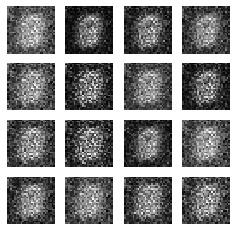

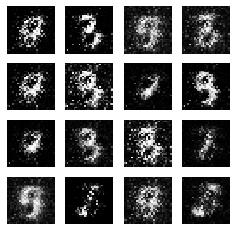

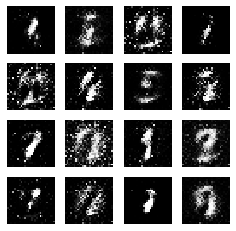

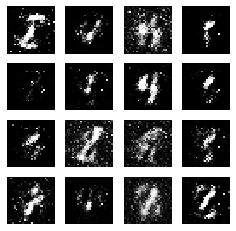

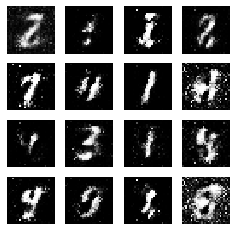

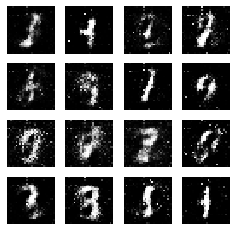

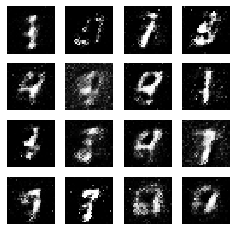

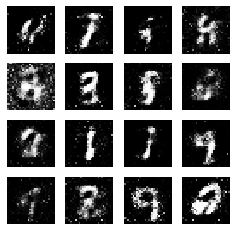

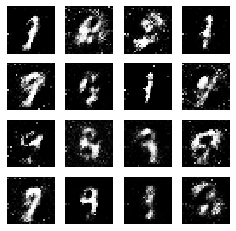

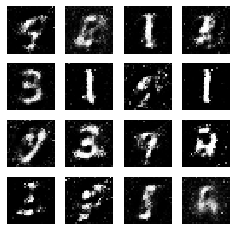

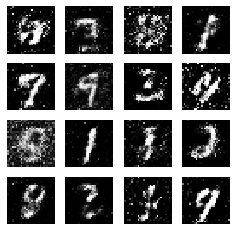

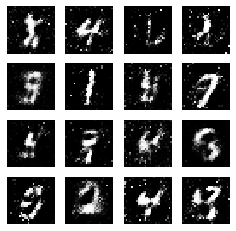

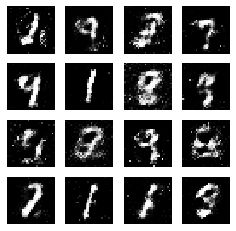

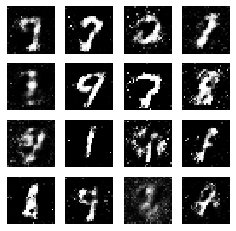

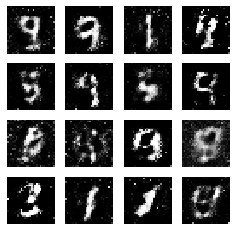

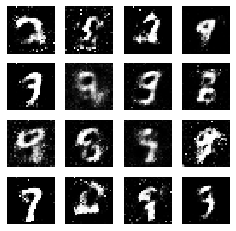

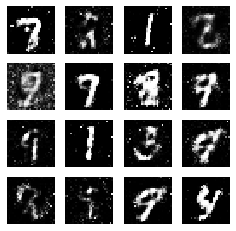

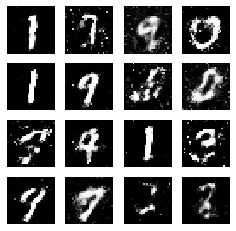

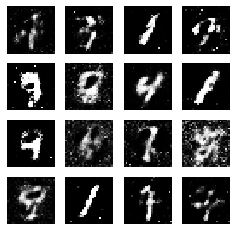

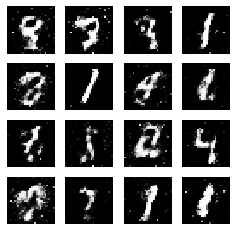

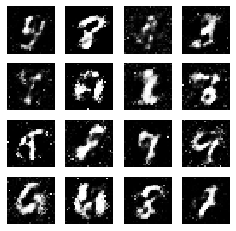

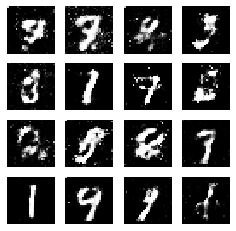

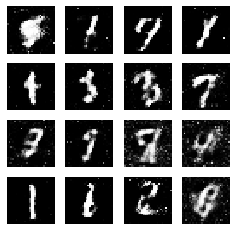

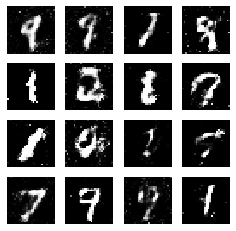

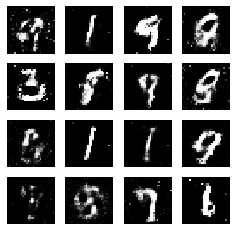

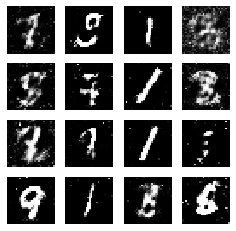

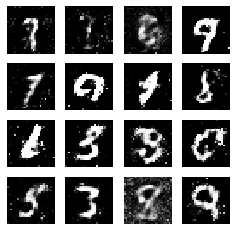

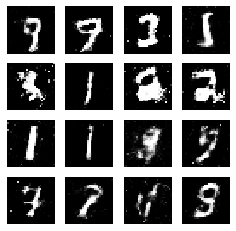

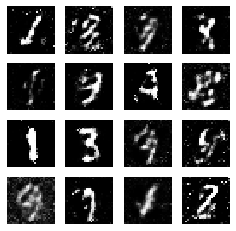

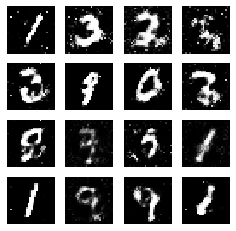

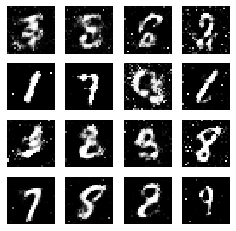

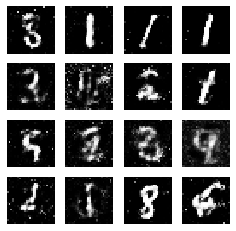

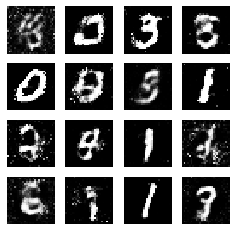

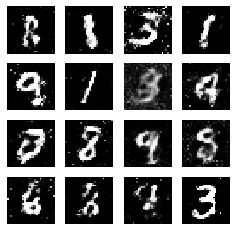

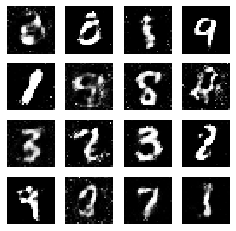

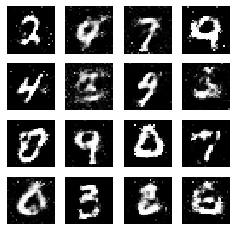

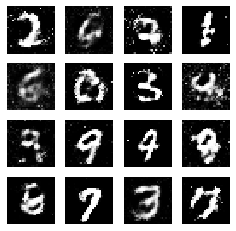

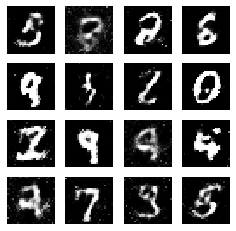

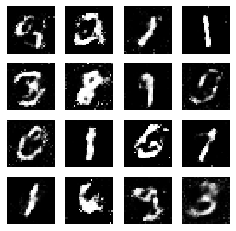

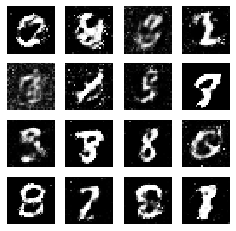

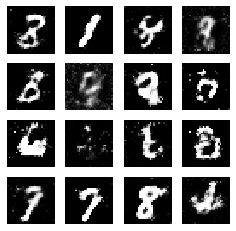

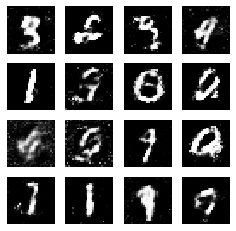

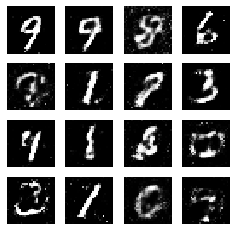

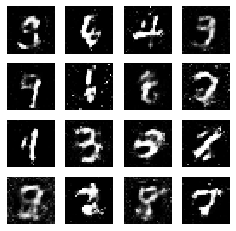

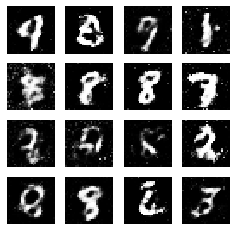

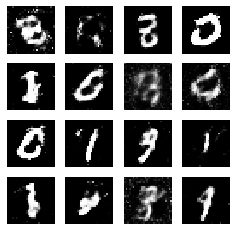

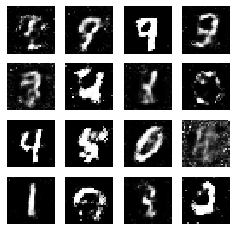

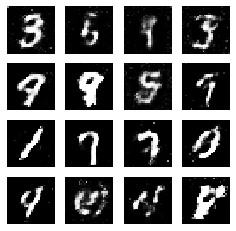

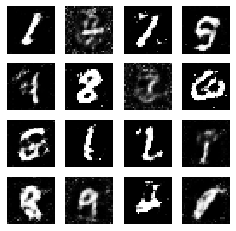

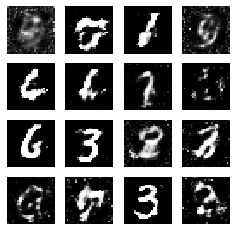

In [9]:
iteractions = 50000
batch_size = 128
sample_interval = 1000

# Train the GAN
train(iteractions, batch_size, sample_interval)

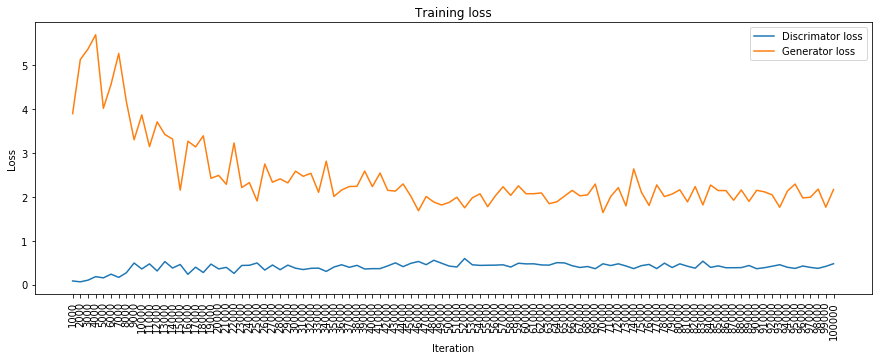

In [10]:
losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discrimator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

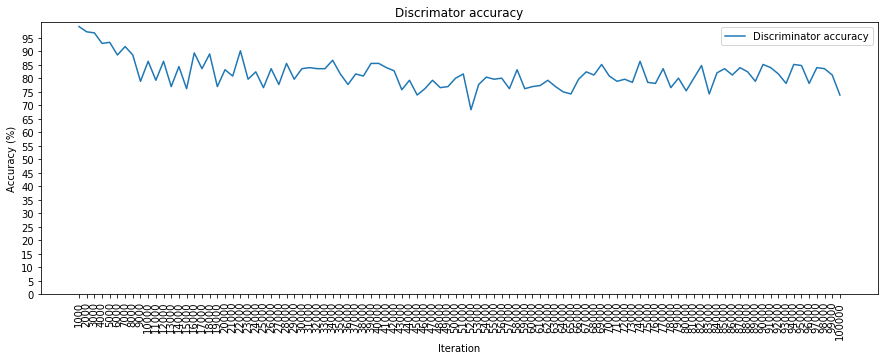

In [11]:
accuracies = np.array(accuracies)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label='Discriminator accuracy')
plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title('Discrimator accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()